### Positional Encoding  
#### 1. 绝对位置编码  
早期模型主要给每个位置分配一个唯一的“身份证”  
- 训练式绝对位置编码：在输入层为每个位置学习一个专门的向量，然后直接加在词向量上。无法处理超过训练长度的文本，扩展性差
- 正弦/余弦位置编码：利用不同频率的正弦和余弦函数生成固定向量：数值稳定在【-1，1】之间，模型可以通过三角函数的线性组合学习到相对位置

#### 2. 旋转位置编码  
RoPe 不再是将向量相加，而是将词向量看作复数平面上的点，根据它所在的位置对其进行角度旋转  


#### 2.1 成对旋转  
RoPE 将 $d_k$ 维向量看作 $d_k$/2 个2D平面上的点。对于位置i的向量，对其每一对元素进行旋转  

##### 2D旋转矩阵向量形式  
$R_{ij} = \begin{bmatrix} cos(\theta_{ij}) & -sin(\theta_{ij}) \\ sin(\theta_{ij}) & cos(\theta_{ij}) \end{bmatrix}$  
- 效果：该矩阵将2D向量旋转 $\theta_{ij}$ 度 
- 全局结构：最终的全局旋转矩阵是由小矩阵构成的分块对角矩阵


#### 2.2 角度$\theta_(i,k)$ 
$$\theta_(i,k) = \frac{1}{1+e^{-\sum_{j=0}^n w_j x_j}}$$

- i:Token在序列中的索引 
- $\theta$:基数  
- k:不同维度对应不同的旋转频率。范围[1,d/2]

#### 2.3 技术细节  
- 相对性：当计算两个词的注意力分数时，数学上可以证明结果只取决于他们之间的角度差(相对距离m-n),而不再受到坐标限制 
- 实施位置：RoPE不在输入层添加，而是在计算Attention之前，对投影的Q，K实施旋转处理  
- 多维度分块:高维向量会被切分成多个2D平面，每个平面应用不同的旋转频率，捕捉不同频率的信息（有的看近，有的看远）

#### 2.4 i与k的理解  
1. i是Token的坐标，代表词在句子中的位置  
2. K是词的标签，代表这个词包含了什么信息  
3. 模型根据i的大小，对K进行特定角度的旋转  

当我们在计算注意力分数时，实际上是在做查询向量 Q 和键向量 K 的点积。通过 RoPE，位置 i 被转化为了旋转矩阵。两个向量点积的结果，将不再取决于它们的绝对位置，而是取决于它们之间的相对角度差（即相对距离 i−j）。这就像是在圆盘上拨动指针，指针间的夹角决定了它们的关联度  

详细示例：“We know" 
- We know that 
  - "we"在位置i=0,其$k_we$ 不旋转（角度为0）  
  - "know"在位置i=1,其$k_{know}$ 旋转一个单位角度$\theta$
  - 他们的相对距离为1-0=1，对应的夹角为$\theta$  
- 句子前面加了词，变成 Of counrse we know  
  - "we" 移动到了位置i=2,其$k_we$ 旋转2$\theta$  
  - "know" 移动到了位置i=3,其$k_{know}$ 旋转3$\theta$
  - 他们的相对距离为3-2=1，对应的家教为$\theta$   
- 模型通过观察K向量被旋转了多少度，就可以精准感知两个词之间的距离，从而更好理解上下文

In [20]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
#中文和负号显示  
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [21]:
input_text = "we know"
tokens = input_text.split()
n_tokens = len(tokens)  # token数量：2
d_model = 2             # 特征维度

In [22]:
# 固定随机种子（Torch+Numpy双种子，保证结果复现）
torch.manual_seed(42)
# 生成随机特征嵌入（Torch张量，模拟token的语义嵌入，形状[seq_len, d_model]）
embeddings = torch.randn(n_tokens, d_model, dtype=torch.float32)

In [ ]:
def rotary_position_embedding_torch(x: torch.Tensor, d_model: int) -> torch.Tensor:
    """
    PyTorch版旋转位置编码核心实现
    :param x: 输入特征张量，形状[seq_len, d_model]
    :param d_model: 特征维度（必须为偶数）
    :return: RoPE编码后的特征张量，形状[seq_len, d_model]
    """
    seq_len = x.shape[0]
    # 生成位置索引：0,1,...,seq_len-1（Torch张量）
    positions = torch.arange(seq_len, dtype=torch.float32)  # [seq_len]
    
    # 生成旋转角频率θ：θ_i = 10000^(-2(i-1)/d_model)，i=1,2,...,d_model/2
    theta = 1.0 / (10000.0 ** (torch.arange(0, d_model, 2, dtype=torch.float32) / d_model))  # [d_model/2]
    
    # 生成位置-频率矩阵mθ：外积计算，每个位置对应所有组的旋转角度 [seq_len, d_model/2]
    m_theta = torch.outer(positions, theta)  
    
    # 构造旋转矩阵的sin/cos矩阵，重复以匹配特征维度 [seq_len, d_model]
    cos_vals = torch.repeat_interleave(torch.cos(m_theta), 2, dim=1)
    sin_vals = torch.repeat_interleave(torch.sin(m_theta), 2, dim=1)
    
    # 特征向量分组旋转：奇偶位分离计算（RoPE核心公式）
    x_rot = torch.zeros_like(x)
    # 奇数列（第1、3...维）：x1*cos - x2*sin
    x_rot[:, 0::2] = x[:, 0::2] * cos_vals[:, 0::2] - x[:, 1::2] * sin_vals[:, 1::2]
    # 偶数列（第2、4...维）：x1*sin + x2*cos
    x_rot[:, 1::2] = x[:, 0::2] * sin_vals[:, 0::2] + x[:, 1::2] * cos_vals[:, 1::2]
    
    return x_rot
rope_embeddings = rotary_position_embedding_torch(embeddings, d_model)

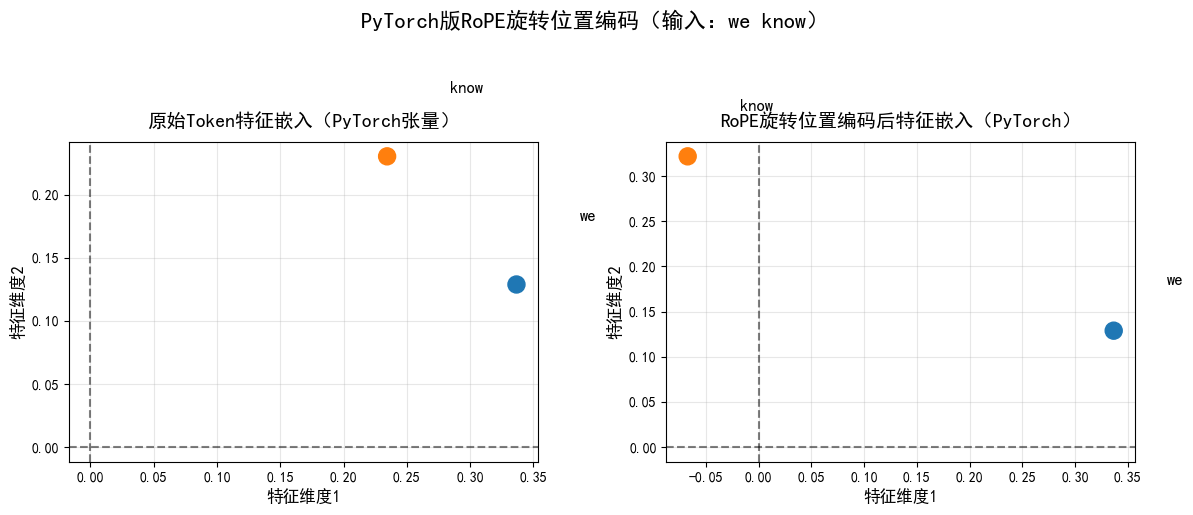

In [24]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
embeddings_np = embeddings.numpy()
rope_embeddings_np = rope_embeddings.numpy()
# 原始Token特征嵌入（2维空间）
ax1.scatter(embeddings_np[:, 0], embeddings_np[:, 1], s=150, c=['#1f77b4', '#ff7f0e'], zorder=3)
for i, token in enumerate(tokens):
    ax1.text(embeddings_np[i, 0]+0.05, embeddings_np[i, 1]+0.05, token, fontsize=12, fontweight='bold')
ax1.set_title('原始Token特征嵌入（PyTorch张量）', fontsize=14, pad=10)
ax1.set_xlabel('特征维度1', fontsize=12)
ax1.set_ylabel('特征维度2', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.axvline(x=0, color='black', linestyle='--', alpha=0.5)

# RoPE编码后特征嵌入（2维旋转效果）
ax2.scatter(rope_embeddings_np[:, 0], rope_embeddings_np[:, 1], s=150, c=['#1f77b4', '#ff7f0e'], zorder=3)
for i, token in enumerate(tokens):
    ax2.text(rope_embeddings_np[i, 0]+0.05, rope_embeddings_np[i, 1]+0.05, token, fontsize=12, fontweight='bold')
ax2.set_title('RoPE旋转位置编码后特征嵌入（PyTorch）', fontsize=14, pad=10)
ax2.set_xlabel('特征维度1', fontsize=12)
ax2.set_ylabel('特征维度2', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.axvline(x=0, color='black', linestyle='--', alpha=0.5)

# 整体标题
fig.suptitle(f'PyTorch版RoPE旋转位置编码（输入：{input_text}）', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

- 左图：原始2维特征嵌入的空间分布  
- 右图：ROPE编码后特征的旋转分布

In [25]:

print(f"输入文本：{input_text} | Token列表：{tokens}")
print("原始Token特征嵌入张量（形状：[token数, 特征维度]）：")
print(torch.round(embeddings, decimals=4))
print("RoPE旋转位置编码后特征嵌入张量：")
print(torch.round(rope_embeddings, decimals=4))


输入文本：we know | Token列表：['we', 'know']
原始Token特征嵌入张量（形状：[token数, 特征维度]）：
tensor([[0.3367, 0.1288],
        [0.2345, 0.2303]])
RoPE旋转位置编码后特征嵌入张量：
tensor([[ 0.3367,  0.1288],
        [-0.0671,  0.3217]])


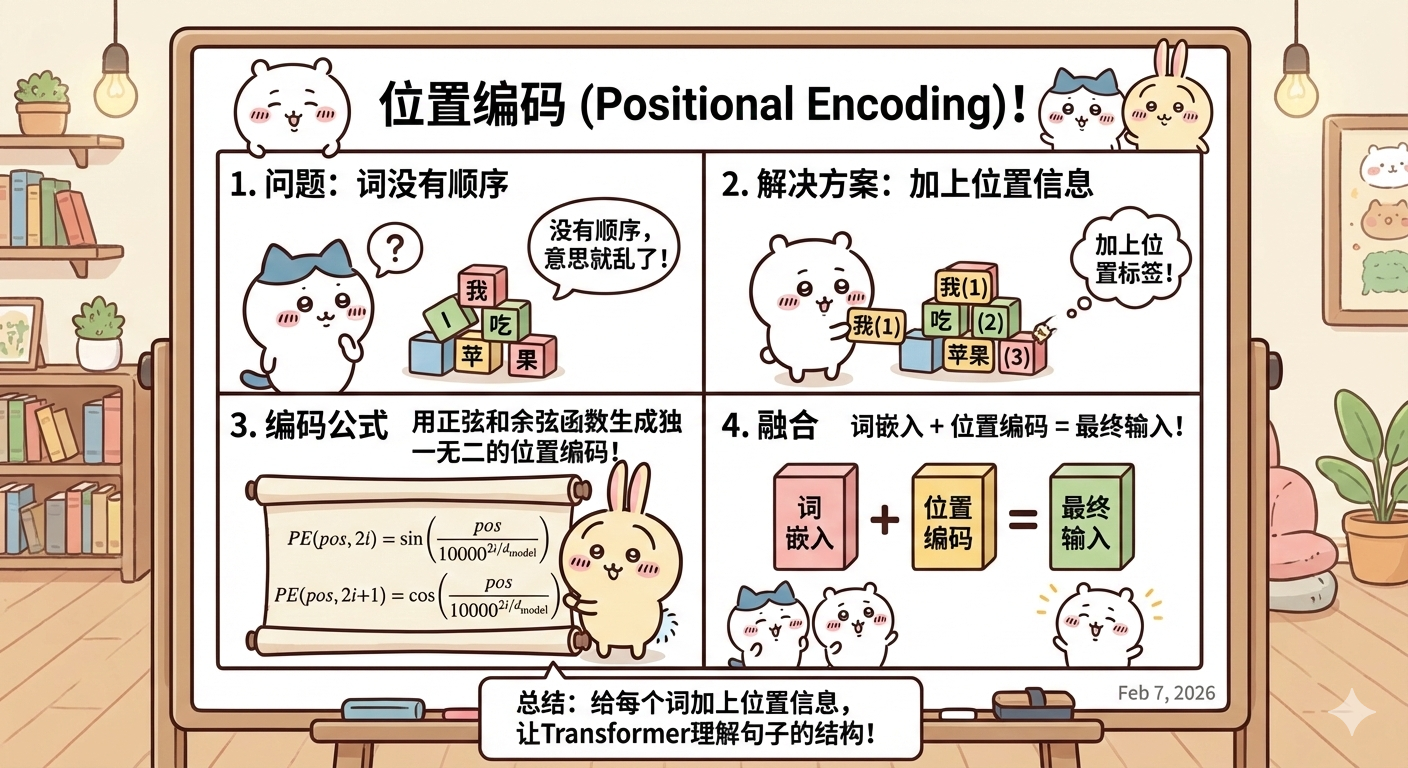